In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Add
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [ ]:
# Function to load data
def load_data(data_dir, target_names):
    img_arr = []
    img_label = []
    label_to_text = {}
    label = 0

    for dir_ in os.listdir(data_dir):
        if dir_ in target_names:
            for f in os.listdir(os.path.join(data_dir, dir_)):
                img = cv2.imread(os.path.join(data_dir, dir_, f), 0)
                img = cv2.resize(img, (48, 48))  # Resize image to 48x48
                img_arr.append(np.expand_dims(img, axis=2))
                img_label.append(label)
            print(f"loaded {dir_} images to numpy arrays...")
            label_to_text[label] = dir_
            label += 1

    img_arr = np.array(img_arr)
    img_label = np.array(img_label)
    img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

    return img_arr, img_label, label_to_text

In [ ]:
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load training data
data_dir_train = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/train/"
img_arr_train, img_label_train, label_to_text_train = load_data(data_dir_train, target_names)

# Load test data
data_dir_test = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/test/"
img_arr_test, img_label_test, label_to_text_test = load_data(data_dir_test, target_names)

INPUT_SHAPE = (48,48,1)
NUM_CLASSES = len(target_names)

loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
total_images_train = 0
for dir_ in os.listdir(data_dir_train):
    if dir_ in target_names:
        count = 0
        for f in os.listdir(data_dir_train + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of training images")
        total_images_train += count

print(f"\ntotal training images are {total_images_train}\n")

surprise has 1290 number of training images
fear has 281 number of training images
angry has 705 number of training images
neutral has 2524 number of training images
sad has 1982 number of training images
disgust has 717 number of training images
happy has 4772 number of training images

total training images are 12271



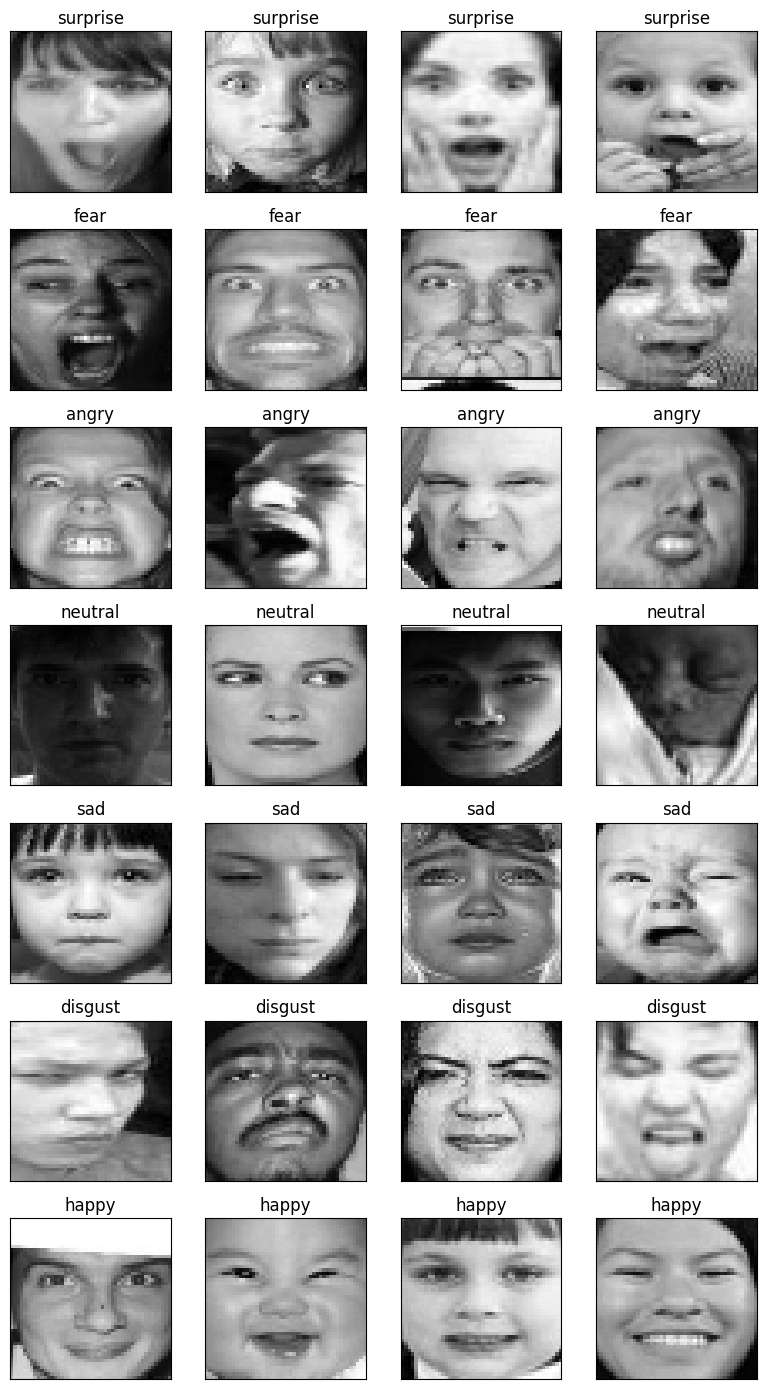

In [ ]:
num_emotions = len(target_names)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text_train:
    sample_indices = np.random.choice(np.where(img_label_train[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr_train[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        ax.imshow(img.reshape(48, 48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text_train[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
def identity_block(X, kernel: tuple, filters: list, stage: int, block_id: str):
    conv_name = 'idblock_conv_' +  str(stage) + f'_{block_id}'
    bn_name = 'idblock_bn_' + str(stage) + f'_{block_id}'
    actv_name = "idblock_actv_" + str(stage) + f'_{block_id}'

    X_shortcut = X

    X = Conv2D(
        filters = filters[0],
        kernel_size = (1, 1),
        strides = (1,1),
        padding = 'valid',
        name = conv_name + '_a',
        kernel_initializer = glorot_uniform(seed=0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_a')(X)
    X = Activation('relu', name = actv_name + '_a')(X)

    X = Conv2D(
        filters = filters[1],
        kernel_size = kernel,
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_b',
        kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_b')(X)
    X = Activation('relu', name = actv_name + '_b')(X)

    X = Conv2D(
        filters = filters[2],
        kernel_size = (1,1),
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_c',
        kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu', name = actv_name + '_c')(X)

    return X

In [ ]:
def convolutional_block(X, kernel: tuple, stride: tuple, filters: list, stage: int, block_id: str):
    conv_name = 'convblock_conv_' + str(stage) + f'_{block_id}'
    bn_name = 'convblock_bn_' + str(stage) + f'_{block_id}'
    actv_name = "convblock_actv_" + str(stage) + f'_{block_id}'

    X_shortcut = X

    X = Conv2D(
        filters[0],
        kernel_size = (1, 1),
        strides = stride,
        name = conv_name + '_a',
        kernel_initializer = glorot_uniform(seed=0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_a')(X)
    X = Activation('relu', name = actv_name + '_a')(X)

    X = Conv2D(
        filters[1],
        kernel_size = kernel,
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_b',
        kernel_initializer=glorot_uniform(seed =0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_b')(X)
    X = Activation('relu', name = actv_name + '_b')(X)

    X = Conv2D(
        filters[2],
        kernel_size = (1,1),
        strides = (1,1),
        padding = 'valid',
        name = conv_name + '_c',
        kernel_initializer=glorot_uniform(seed =0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_c')(X)

    X_shortcut = Conv2D(
        filters[2],
        kernel_size = (1,1),
        strides = stride,
        padding = 'valid',
        name = conv_name + '_sc1',
        kernel_initializer=glorot_uniform(seed =0)
    )(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name + '_sc1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu', name = actv_name + '_c')(X)

    return X

In [ ]:
def CNN_with_SkipConnections(input_shape, classes, show_summary=False):
    model_in = Input(input_shape)

    X = Conv2D(
        filters = 32,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'valid',
        name = 'conv_0_a',
        kernel_initializer = glorot_uniform(seed=0)
    )(model_in)
    X = BatchNormalization(axis = 3, name = 'bn_0_a')(X)
    X = Activation('relu', name="actv_0_a")(X)

    X = Conv2D(
        filters = 64,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'valid',
        name = 'conv_0_b',
        kernel_initializer = glorot_uniform(seed=0)
    )(X)
    X = BatchNormalization(axis = 3, name = 'bn_0_b')(X)
    X = Activation('relu', name="actv_0_b")(X)

    # Block 0
    X = convolutional_block(model_in, (3,3), stride=(1,1), filters = [32, 32, 64], stage=0, block_id='a')
    X = identity_block(X, (3,3), [32, 32, 64], stage=0, block_id='a')

    # Block 1
    X = convolutional_block(X, (3,3), stride=(2,2), filters = [64, 64, 128], stage=1, block_id='a')
    X = identity_block(X, (3,3), [64, 64, 128], stage=1, block_id='a')

    # Block 2
    X = convolutional_block(X, (3,3), stride=(2,2), filters = [128,128,256], stage=2, block_id='a')
    X = identity_block(X, (2,2), [128,128,256], stage=2, block_id='a')

    X = AveragePooling2D(pool_size=(2, 2))(X)

    X = Flatten()(X)
    X = Dense(
        128,
        kernel_initializer = glorot_uniform(seed=0),
        name = 'dense_1',
    )(X)
    X = BatchNormalization(name = 'bn_3')(X)
    X = Activation('relu', name="actv_3")(X)

    model_out = Dense(classes, activation='softmax', name="out_layer")(X)

    model = Model(inputs = model_in, outputs = model_out, name='CNN_with_SkipConnections')

    if show_summary:
        model.summary()

    return model

In [ ]:
# Define a custom callback for early stopping based on validation accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=10, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best = -np.Inf  # Initialize best to negative infinity
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best:
            self.best = current_val_acc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Save the best weights
        elif epoch - self.best_epoch >= self.patience:
            print(f"Epoch {epoch}: Early stopping due to no improvement in {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print(f"Restoring best weights from epoch {self.best_epoch}.")
                self.model.set_weights(self.best_weights)

Model: "CNN_with_SkipConnections"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_conv_0_a… │ (None, 48, 48,    │         64 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_bn_0_a_a  │ (None, 48, 48,    │        128 │ convblock_conv_0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_actv_0_a… │ (None, 48, 48,    │          0 │ convblock_bn_0_a… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_conv_0_a… │ (None, 48, 48,    │      9,248 │ convblock_actv_0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_bn_0_a_b  │ (None, 48, 48,    │        128 │ convblock_conv_0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_actv_0_a… │ (None, 48, 48,    │          0 │ convblock_bn_0_a… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_conv_0_a… │ (None, 48, 48,    │      2,112 │ convblock_actv_0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_conv_0_a… │ (None, 48, 48,    │        128 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_bn_0_a_c  │ (None, 48, 48,    │        256 │ convblock_conv_0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_bn_0_a_s… │ (None, 48, 48,    │        256 │ convblock_conv_0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 48,    │          0 │ convblock_bn_0_a… │
│                     │ 64)               │            │ convblock_bn_0_a… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convblock_actv_0_a… │ (None, 48, 48,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ idblock_conv_0_a_a  │ (None, 48, 48,    │      2,080 │ convblock_actv_0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ idblock_bn_0_a_a    │ (None, 48, 48,    │        128 │ idblock_conv_0_a… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ idblock_actv_0_a_a  │ (None, 48, 48,    │          0 │ idblock_bn_0_a_a… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ idblock_conv_0_a_b  │ (None, 48, 48,    │      9,248 │ idblock_actv_0_a

 Total params: 1,688,103 (6.44 MB)

 Trainable params: 1,683,367 (6.42 MB)

 Non-trainable params: 4,736 (18.50 KB)

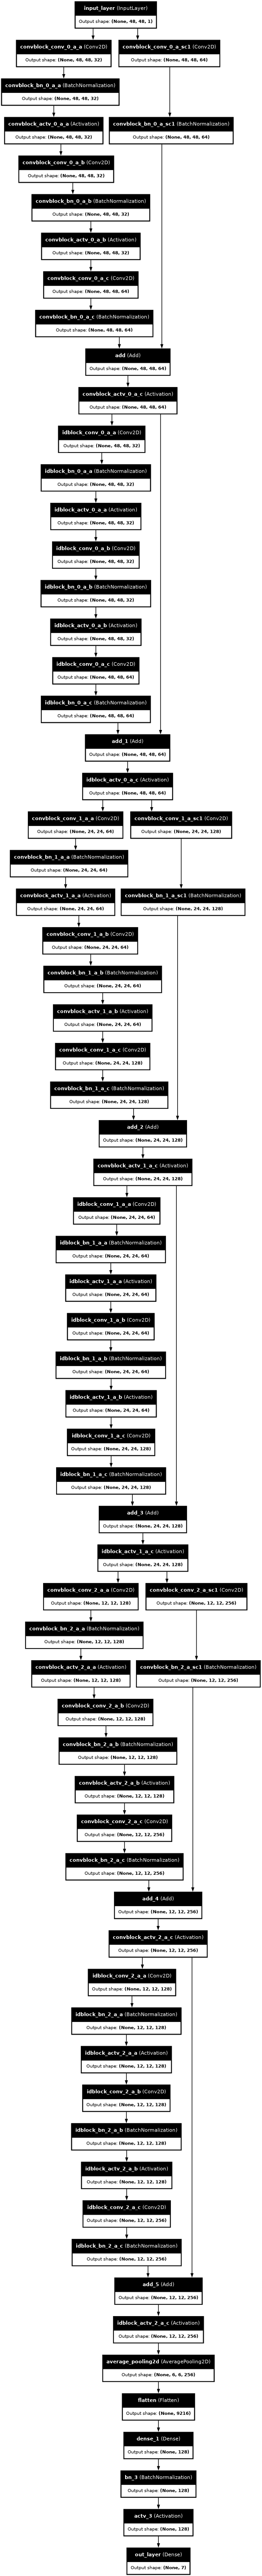

In [ ]:
model = CNN_with_SkipConnections(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.2,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=7,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
batch_size = 32
loss = "categorical_crossentropy"
optim = optimizers.Adam(0.001)
epochs = 100

In [ ]:
model.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy'],
)

train_datagen.fit(img_arr_train)

# Training the model
custom_early_stopping = CustomEarlyStopping(patience=15)
history_ResNet = model.fit(
    train_datagen.flow(img_arr_train, img_label_train, batch_size=batch_size),
    validation_data=(img_arr_test, img_label_test),
    steps_per_epoch=int(len(img_arr_train) / batch_size),
    epochs = epochs,
    callbacks = [lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/383 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.0972 - loss: 2.8761   

I0000 00:00:1711956379.478017     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711956379.522924     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


339/383 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.3993 - loss: 1.6786

W0000 00:00:1711956399.941665     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4082 - loss: 1.6516

W0000 00:00:1711956403.153801     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.4084 - loss: 1.6510 - val_accuracy: 0.5062 - val_loss: 1.3855 - learning_rate: 0.0010
Epoch 2/100
  1/383 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6875 - loss: 0.9043

W0000 00:00:1711956406.446610     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.9043 - val_accuracy: 0.5140 - val_loss: 1.3292 - learning_rate: 0.0010
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5777 - loss: 1.1572 - val_accuracy: 0.6037 - val_loss: 1.1110 - learning_rate: 0.0010
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.8373 - val_accuracy: 0.6053 - val_loss: 1.1039 - learning_rate: 0.0010
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6450 - loss: 0.9778 - val_accuracy: 0.6900 - val_loss: 0.8826 - learning_rate: 0.0010
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.8988 - val_accuracy: 0.6900 - val_loss: 0.8824 - learning_rate: 0.0010
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6814 - loss: 0.8775 - val_accuracy: 0.6653 - val_loss: 0.9165 - learning_rate: 0.0010
Epoch 8/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 1.2918 -

In [ ]:
history = pd.DataFrame(history_ResNet.history)
history

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.482229,1.428399,0.506193,1.385530,1.000000e-03
1,0.687500,0.904290,0.514016,1.329245,1.000000e-03
2,0.598823,1.100292,0.603651,1.111018,1.000000e-03
3,0.687500,0.837291,0.605280,1.103938,1.000000e-03
4,0.647929,0.962887,0.690026,0.882563,1.000000e-03
5,0.750000,0.898785,0.690026,0.882390,1.000000e-03
6,0.682000,0.877054,0.665254,0.916467,1.000000e-03
7,0.437500,1.291752,0.664928,0.910798,1.000000e-03
8,0.706675,0.825468,0.703064,0.831095,1.000000e-03
9,0.718750,0.968982,0.713494,0.812889,1.000000e-03


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

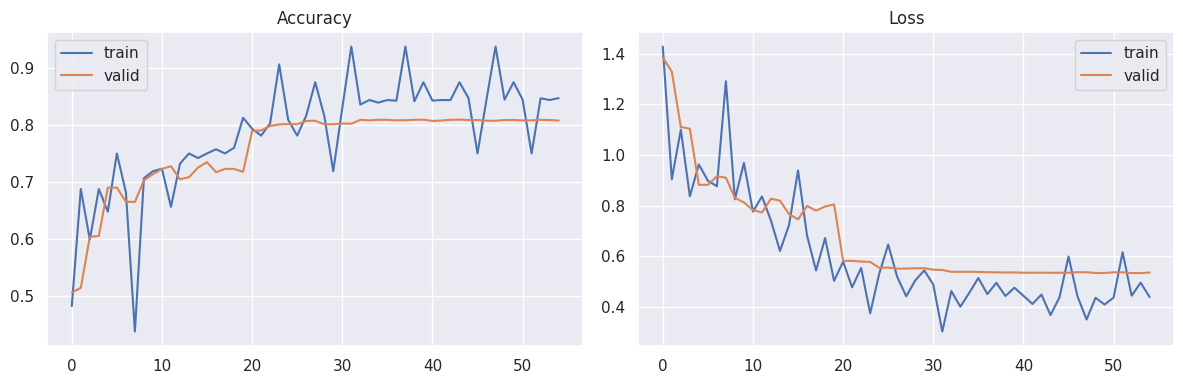

In [ ]:
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_ResNet.epoch, y=history_ResNet.history['accuracy'], label='train')
sns.lineplot(x=history_ResNet.epoch, y=history_ResNet.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_ResNet.epoch, y=history_ResNet.history['loss'], label='train')
sns.lineplot(x=history_ResNet.epoch, y=history_ResNet.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

384/384 - 3s - 9ms/step - accuracy: 0.8821 - loss: 0.3459


W0000 00:00:1711956710.150722     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



train Accuracy: 0.8820797204971313
96/96 - 1s - 6ms/step - accuracy: 0.8093 - loss: 0.5366

Test Accuracy: 0.8093220591545105
30/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1711956712.459240     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


W0000 00:00:1711956714.574858     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Classification Report:
               precision    recall  f1-score   support

       angry       0.85      0.80      0.83       329
     disgust       0.60      0.55      0.58        74
        fear       0.69      0.78      0.73       162
       happy       0.76      0.78      0.77       680
     neutral       0.71      0.79      0.74       478
         sad       0.50      0.36      0.42       160
    surprise       0.94      0.91      0.93      1185

    accuracy                           0.81      3068
   macro avg       0.72      0.71      0.71      3068
weighted avg       0.81      0.81      0.81      3068



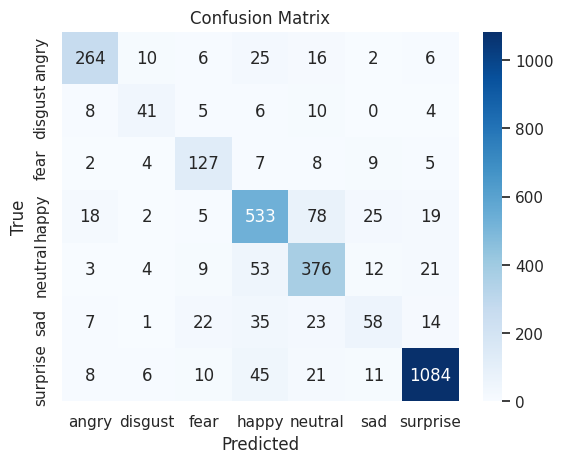

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(img_arr_train, img_label_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(img_arr_test, img_label_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(img_arr_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(img_label_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

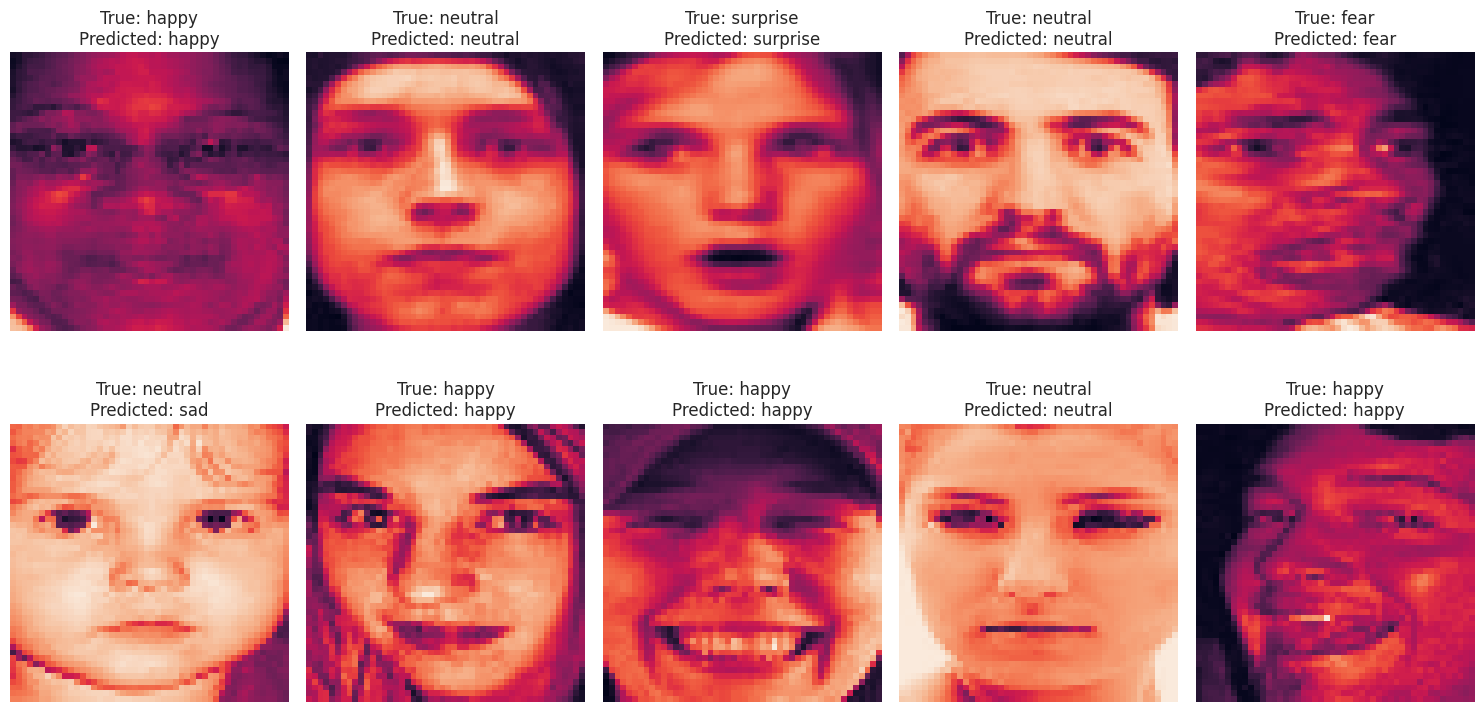

In [ ]:
import random

# Visualize some predictions
num_images_to_visualize = 10
random_indices = np.random.choice(len(img_arr_test), size=num_images_to_visualize, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_arr_test[idx])
    plt.title(f"True: {label_to_text_test[true_labels[idx]]}\nPredicted: {label_to_text_test[predicted_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()